## FOMC-RoBERT Model
We use the FOMC-RoBERTa model to classify sentences based on their hawkish or dovish tone. This pretrained model comes from the paper "Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis." The model was trained on three types of datasets: FOMC Meeting Minutes, Press Conferences, and Speeches, which align well with our dataset.

The model assigns one of three labels to each sentence:

 **LABEL_2: Neutral   
LABEL_1: Hawkish  
LABEL_0: Dovish**  
However, we don't use all sentences from the raw text. As discussed in the main notebook, we preprocessed the text to filter out irrelevant sentences. The resulting cleaned data was saved into two files: **cleaned_minutes_texts.csv** and **cleaned_speeches_texts.csv**. These preprocessed sentences serve as input to the classification model.

After labeling all filtered sentences from the meeting minutes, speeches, and press conferences, we construct the hawkish measure for each document, following the formula outlined in the paper.  

@article{shah2023trillion,   
  title={Trillion Dollar Words: A New Financial Dataset, Task & Market Analysis},  
  author={Shah, Agam and Paturi, Suvan and Chava, Sudheer},  
  journal={Available at SSRN 4447632},  
  year={2023}  
}

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00


In [67]:
import csv
import pandas as pd
from datasets import Dataset
import re

In [66]:
# Load predefined model parameters from the paper

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("gtfintechlab/FOMC-RoBERTa", do_lower_case=True, do_basic_tokenize=True)
# Load the pretrained FOMC-RoBERTa model for sequence classification with 3 labels (Neutral, Hawkish, Dovish)
model = AutoModelForSequenceClassification.from_pretrained("gtfintechlab/FOMC-RoBERTa", num_labels=3)
config = AutoConfig.from_pretrained("gtfintechlab/FOMC-RoBERTa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [68]:
# Read the cleaned sentences of FOMC Minutes and Press Conference from the 'cleaned_minutes_texts.csv' file into a dictionary
cleaned_minutes_texts = {}
with open('/content/drive/MyDrive/cleaned_minutes_texts.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        file_name, content = row
        cleaned_minutes_texts[file_name] = content

# Read the cleaned sentences of Fed Speeches from the 'cleaned_speeches_texts.csv' file into a dictionary
cleaned_speeches_texts = {}
with open('/content/drive/MyDrive/cleaned_speeches_texts.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    for row in reader:
        file_name, content = row
        cleaned_speeches_texts[file_name] = content

Below is a **test** case provided by the authors. It includes two example sentences:

"Such a directive would imply that any tightening should be implemented promptly if developments were perceived as pointing to rising inflation."
"The International Monetary Fund projects that global economic growth in 2019 will be the slowest since the financial crisis."

The classification results show that the **first** sentence is labeled as **hawkish**, while the **second** is labeled as **dovish**.

In [69]:
# Test case to classify a couple of example sentences using the FOMC-RoBERTa model
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, config=config, device=0, framework="pt")

# Classifying two example sentences
results = classifier([
    "Such a directive would imply that any tightening should be implemented promptly if developments were perceived as pointing to rising inflation.",
    "The International Monetary Fund projects that global economic growth in 2019 will be the slowest since the financial crisis."
], batch_size=128, truncation="only_first")

# Print classification results for the test sentences
print(results)


[{'label': 'LABEL_1', 'score': 0.999393105506897}, {'label': 'LABEL_0', 'score': 0.9979877471923828}]


Next, we will use the FOMC meeting minutes from January 25, 2012, to examine the classification results.

In [70]:
# Test case for the minutes_20120125
# Split the content of cleaned_minutes_texts['minutes_20120125.txt'] using commas and quotes
minutes_text = cleaned_minutes_texts['minutes_20120125.txt']
# Split sentences by commas, and remove quotes and any leading/trailing spaces
sentences = [sentence.strip().strip('"') for sentence in minutes_text.split(',')]

# Classify each sentence
results = classifier(sentences, batch_size=128, truncation="only_first")

# Define the label mapping
label_map = {
    "LABEL_2": "Neutral",
    "LABEL_1": "Hawkish",
    "LABEL_0": "Dovish"
}

# Initialize counters and a dictionary for storing sentences for each label
label_counts = {"Neutral": 0, "Hawkish": 0, "Dovish": 0}
label_sentences = {"Neutral": [], "Hawkish": [], "Dovish": []}  # Dictionary to store sentences by label

# Classify each sentence and categorize by label
for sentence, result in zip(sentences, results):
    label = result['label']  # Get the label from the model's result
    label_text = label_map.get(label, "Unknown")  # Map the label to the corresponding text

    print(f"Sentence: {sentence}")
    print(f"Classification: {label_text}\n")

    # Increment the count for the respective label
    if label_text in label_counts:
        label_counts[label_text] += 1
        label_sentences[label_text].append(sentence)  # Add the sentence to the corresponding label's list

Sentence: ['however a third study which employed householdlevel data suggested that movements in consumption before during and after the recession were driven primarily by employment income and net worth leaving little variation to be explained by changes in leverage and credit availability'
Classification: Neutral

Sentence: 'participants also considered the possible influence on aggregate consumer spending of changes in real interest rates and the distribution of income the potential for policy actions to affect the fundamental factors driving household saving and whether households spending behavior is being affected by concerns about the future of social security'
Classification: Neutral

Sentence: 'to buy or sell u.s. government securities including securities of the federal financing bank and securities that are direct obligations of or fully guaranteed as to principal and interest by any agency of the united states in the open market from or to securities dealers and foreign and

In [71]:
# Print the sentences classified under each label
for label, sentence_list in label_sentences.items():
    print(f"\nSentences classified as {label}:")
    for sent in sentence_list:
        print(f"- {sent}")


Sentences classified as Neutral:
- ['however a third study which employed householdlevel data suggested that movements in consumption before during and after the recession were driven primarily by employment income and net worth leaving little variation to be explained by changes in leverage and credit availability'
- 'participants also considered the possible influence on aggregate consumer spending of changes in real interest rates and the distribution of income the potential for policy actions to affect the fundamental factors driving household saving and whether households spending behavior is being affected by concerns about the future of social security'
- 'to buy or sell u.s. government securities including securities of the federal financing bank and securities that are direct obligations of or fully guaranteed as to principal and interest by any agency of the united states in the open market from or to securities dealers and foreign and international accounts maintained at th

In [72]:
# Calculate total number of sentences
total_sentences = len(sentences)

# Calculate and print the proportion of each label
print(f"Total number of filtered sentences: {total_sentences}")
for label, count in label_counts.items():
    proportion = count / total_sentences * 100  # Calculate percentage
    print(f"{label} sentences: {count} ({proportion:.2f}%)")

Total number of filtered sentences: 228
Neutral sentences: 163 (71.49%)
Hawkish sentences: 22 (9.65%)
Dovish sentences: 43 (18.86%)


For the FOMC Meeting Minutes on January 25, 2012, there are 228 relevant sentences after filtering, with approximately 71% identified as neutral, and 10% as hawkish while 19% classified as dovish. The large amount of neutral sentences aligns with the Federal Reserve's general approach. As stated in the paper:"the Federal Reserve deliberately aims to maintain financial and economic stability, ensuring that any statements they make are presented in a measured, moderate manner to minimize the risk of excessive market reactions."

Next, we will compute the document-level hawkishness using the formula in the paper: $$ \text{Measure}_i = \frac{\#\text{Hawkish}_i - \#\text{Dovish}_i}{\#\text{Total}_i} $$ To calculate this measure, the model will analyze each sentence in the document. We will then count and sum the number of hawkish and dovish sentences.

In [73]:
# Initialize a dictionary to store the combined data
data = {
    'file_name': [],
    'sentence': [],
    'source': []
}

# Populate data with sentences from minutes
for file_name, minutes_text in cleaned_minutes_texts.items():
    sentences = [sentence.strip().strip('"') for sentence in minutes_text.split(',')]

    # Determine source based on file name
    if file_name.startswith('minutes_'):
        source_type = 'minutes'
    elif file_name.startswith('press_conf_'):
        source_type = 'press'
    else:
        source_type = 'unknown'

    for sentence in sentences:
        data['file_name'].append(file_name)
        data['sentence'].append(sentence)
        data['source'].append(source_type)

# Populate data with sentences from speeches
for file_name, speeches_text in cleaned_speeches_texts.items():
    sentences = [sentence.strip().strip('"') for sentence in speeches_text.split(',')]

    # Speeches are assumed to be speeches, based on the context
    source_type = 'speeches'

    for sentence in sentences:
        data['file_name'].append(file_name)
        data['sentence'].append(sentence)
        data['source'].append(source_type)

# Convert the combined data into a Dataset object
dataset = Dataset.from_dict(data)

In [74]:
# Use the dataset to classify sentences in a more efficient way
def classify_sentence(examples):
    results = classifier(examples['sentence'], truncation="only_first")
    labels = [label_map[result['label']] for result in results]
    return {'label': labels}

# Apply classification to the dataset
classified_dataset = dataset.map(classify_sentence, batched=True)

# Convert to a DataFrame for easier manipulation, including the 'source' column to track the origin of the sentences
df = pd.DataFrame({
    'File Name': classified_dataset['file_name'],
    'Sentence': classified_dataset['sentence'],
    'Label': classified_dataset['label'],
    'Source': classified_dataset['source']  # Include the source (minutes, press, or speeches)
})

# Save the results to a CSV file
df.to_csv('classified_sentences.csv', index=False)

Map:   0%|          | 0/44637 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [75]:
# Display the results
df.tail()

,File Name,Sentence,Label,Source
44632,yellen20171020a.txt,'second in light of evidence suggesting that t...,Neutral,speeches
44633,yellen20171020a.txt,'for this reason we must keep our unconvention...,Dovish,speeches
44634,yellen20171107a.txt,['he also helped governors in pennsylvania and...,Neutral,speeches
44635,yellen20171107a.txt,'but over time douglass stand changed both the...,Neutral,speeches
44636,yellen20171107a.txt,'the federal reserves very effectiveness in se...,Neutral,speeches


The file "classified_sentences.csv" shows the label for each filtered sentence, next we construct the dataframe that measures the level of hawkishness for each document and the corresponding date of the meeting or speech.

In [77]:
# Function to extract date from the file name using regex for common date formats (e.g., YYYYMMDD)
def extract_date(file_name):
    # Look for a pattern of 8 consecutive digits (e.g., 20120125 for January 25, 2012)
    match = re.search(r'\d{8}', file_name)
    if match:
        return match.group(0)  # Return the matched date (YYYYMMDD)

    # If no 8-digit date is found, you can extract other patterns or parts of the filename
    # Example: extracting the first part of the filename before numbers
    match = re.search(r'[a-zA-Z]+(\d{6,8})', file_name)
    if match:
        return match.group(1)  # Extract date-like part (e.g., yellen20171020a -> 20171020)

    # Fallback: return the entire file name if no date-like structure is found
    return file_name

# Initialize an empty list to store the final results
hawish_measure_data = []

# Group the DataFrame by 'File Name' to calculate the hawkish measure for each file
for file_name, group in df.groupby('File Name'):
    total_sentences = len(group)  # Total number of sentences in the file
    hawkish_count = (group['Label'] == 'Hawkish').sum()  # Number of hawkish sentences
    dovish_count = (group['Label'] == 'Dovish').sum()  # Number of dovish sentences

    # Calculate the hawkish measure: (#Hawkish - #Dovish) / total number of sentences
    hawkish_measure = (hawkish_count - dovish_count) / total_sentences

    # Extract the date from the file name using the custom function
    file_date = extract_date(file_name)

    # Extract the source information from the group (assuming it's consistent within the group)
    source = group['Source'].iloc[0]

    # Append the result to the list
    hawish_measure_data.append([file_date, file_name, hawkish_measure, source])

# Create a new DataFrame with the results
hawkish_df = pd.DataFrame(hawish_measure_data, columns=['Date', 'File Name', 'Hawkish Measure', 'Source'])

# Optionally, save the new DataFrame to a CSV file
hawkish_df.to_csv('hawkish_measure.csv', index=False)

In [107]:
hawkish_df['Date'] = pd.to_datetime(hawkish_df['Date'], format='%Y%m%d', errors='coerce')
df = hawkish_df.sort_values(by='Date')

df.head(10)

,Date,File Name,Hawkish Measure,Source
21,2011-02-10,bernanke20110210a.txt,-0.300000,speeches
324,2012-01-06,duke20120106a.txt,-0.370370,speeches
740,2012-01-06,raskin20120106a.txt,-0.227273,speeches
741,2012-01-07,raskin20120107a.txt,-0.666667,speeches
325,2012-01-13,duke20120113a.txt,-0.125000,speeches
326,2012-01-16,duke20120116a.txt,-0.115385,speeches
405,2012-01-25,minutes_20120125.txt,-0.092105,minutes
611,2012-01-25,press_conf_20120125.txt,-0.214286,press
22,2012-02-16,bernanke20120216a.txt,-0.444444,speeches
742,2012-03-01,raskin20120301a.txt,-0.214286,speeches


As we see, there might be more than two documents on the same day. To better measure the market reaction on a particular day when there are multiple documents (e.g., minutes and press conferences, or multiple speeches), we will compute the **average** 'Hawkish Measure' of all documents on the same day.

In [108]:
def average_hawkish_measure_by_date(df):
    """
    Calculates the average Hawkish Measure for each unique date in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing at least 'Date' and 'Hawkish Measure' columns.

    Returns:
        pd.DataFrame: A new DataFrame where the 'Hawkish Measure' for each date is averaged.
    """
    # Group by 'Date' and calculate the average 'Hawkish Measure' for each group
    df_avg = df.groupby('Date', as_index=False).agg({
        'Hawkish Measure': 'mean',
        'Source': lambda x: ', '.join(set(x)),  # Optionally, combine unique sources
        'File Name': lambda x: ', '.join(x)  # Optionally, combine file names
    })

    return df_avg

# Apply the function
df = average_hawkish_measure_by_date(df)

# Show the summed DataFrame
df.head(10)

,Date,Hawkish Measure,Source,File Name
0,2011-02-10,-0.300000,speeches,bernanke20110210a.txt
1,2012-01-06,-0.298822,speeches,"duke20120106a.txt, raskin20120106a.txt"
2,2012-01-07,-0.666667,speeches,raskin20120107a.txt
3,2012-01-13,-0.125000,speeches,duke20120113a.txt
4,2012-01-16,-0.115385,speeches,duke20120116a.txt
5,2012-01-25,-0.153195,"minutes, press","minutes_20120125.txt, press_conf_20120125.txt"
6,2012-02-16,-0.444444,speeches,bernanke20120216a.txt
7,2012-03-01,-0.214286,speeches,raskin20120301a.txt
8,2012-03-13,0.030000,minutes,minutes_20120313.txt
9,2012-03-23,0.000000,speeches,bernanke20120323a.txt


In [109]:
# Count the number of rows where Hawkish Measure is equal to 0
zero_count = (df['Hawkish Measure'] == 0).sum()

# Count the total number of rows in Hawkish Measure column
total_count = df['Hawkish Measure'].count()

print(f"Number of documents with Hawkish Measure equal to 0: {zero_count}")
print(f"Total number of relevant documents: {total_count}")

Number of documents with Hawkish Measure equal to 0: 182
Total number of relevant documents: 716


After preprocessing, we obtained 716 effective observations for the level of hawkishness, with 182 of them measured as having a neutral tone.  
Next, we will use this data to do regression analysis.

## Regression Analysis, Intepretation & Conclusion For Method Two
First, let's analyze the 2-year to 10-year yield spread. Typically, when hawkish sentiment occurs, the spread narrows (flattening or even inverting), whereas dovish sentiment tends to widen the spread. For Method 2, the key variable is the level of hawkishness—the larger this value, the more hawkish the text is. We will begin by loading the provided market data.



In [110]:
spread = pd.read_excel('/content/drive/MyDrive/210spread.xlsx')
# Convert 'Date' to datetime
spread['Date'] = pd.to_datetime(spread['Date'])
# Set 'Date' as the index and sort in descending order
spread.set_index('Date', inplace=True)
spread = spread.iloc[:, :3]
spread.sort_index(ascending=True, inplace=True)
# Check the first few rows
print(spread.head())

             PX_LAST  Change  % Change
Date                                  
2011-12-30  163.5993     NaN       NaN
2012-01-02  163.5993     NaN       NaN
2012-01-03  169.1294     NaN       NaN
2012-01-04  171.6850     NaN       NaN
2012-01-05  173.4169     NaN       NaN


In [111]:
spread['Change'] = spread['PX_LAST'].diff()
spread['% Change'] = spread['PX_LAST'].pct_change() * 100
spread['next_change'] = spread['Change'].shift(-1)

In [112]:
spread.head()

,PX_LAST,Change,% Change,next_change
Date,,,,
2011-12-30,163.5993,NaN,NaN,0.0000
2012-01-02,163.5993,0.0000,0.000000,5.5301
2012-01-03,169.1294,5.5301,3.380271,2.5556
2012-01-04,171.6850,2.5556,1.511032,1.7319
2012-01-05,173.4169,1.7319,1.008766,-3.3382


In [113]:
# file_path = '/content/drive/MyDrive/hawkish_measure.csv'
# df = pd.read_csv(file_path)
df.head()

,Date,Hawkish Measure,Source,File Name
0,2011-02-10,-0.300000,speeches,bernanke20110210a.txt
1,2012-01-06,-0.298822,speeches,"duke20120106a.txt, raskin20120106a.txt"
2,2012-01-07,-0.666667,speeches,raskin20120107a.txt
3,2012-01-13,-0.125000,speeches,duke20120113a.txt
4,2012-01-16,-0.115385,speeches,duke20120116a.txt


In [114]:
spread.index = pd.to_datetime(spread.index, errors='coerce')

regress = df.copy()
regress = pd.merge(regress, spread[['next_change']], left_on='Date', right_index=True, how='inner')

print(regress.head())

        Date  Hawkish Measure          Source  \
1 2012-01-06        -0.298822        speeches   
3 2012-01-13        -0.125000        speeches   
4 2012-01-16        -0.115385        speeches   
5 2012-01-25        -0.153195  minutes, press   
6 2012-02-16        -0.444444        speeches   

                                       File Name  next_change  
1         duke20120106a.txt, raskin20120106a.txt       1.1750  
3                              duke20120113a.txt       0.0000  
4                              duke20120116a.txt      -0.3094  
5  minutes_20120125.txt, press_conf_20120125.txt      -5.1518  
6                          bernanke20120216a.txt       1.8807  


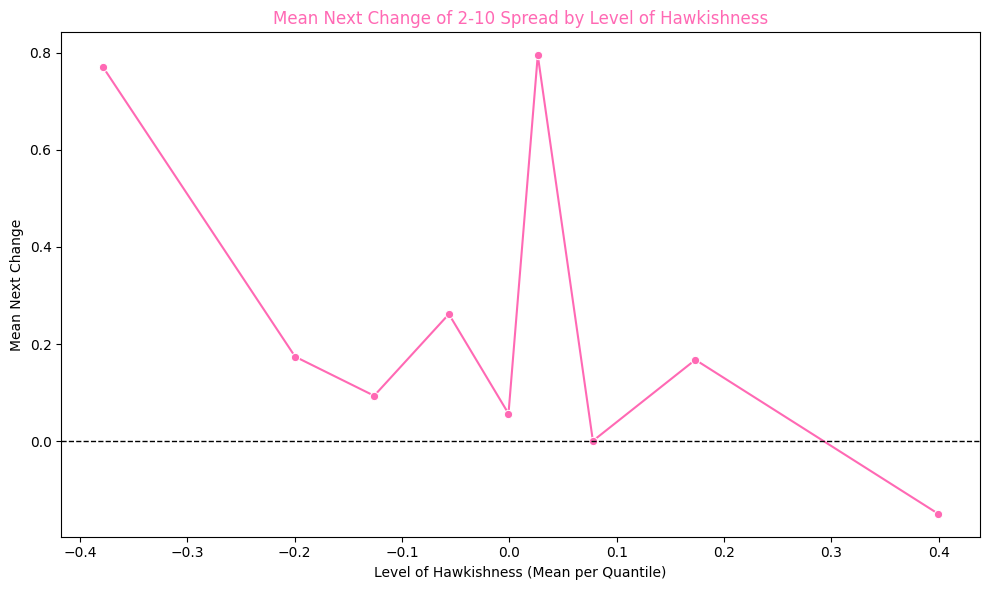

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 10

# Create quantile bins for hawkish measure, handling duplicate bin edges
regress['hawkish_quantile'] = pd.qcut(regress['Hawkish Measure'], q=n_quantiles, labels=False, duplicates='drop')

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'next_change': 'mean', 'Hawkish Measure': 'mean'})

# Create the figure for the line plot
plt.figure(figsize=(10, 6))

# Plot: Hawkish measure quantile vs mean 'next_change'
sns.lineplot(x=hawkish_grouped['Hawkish Measure'], y=hawkish_grouped['next_change'], color='#FF69B4', marker='o')
# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# Add titles and labels
plt.title('Mean Next Change of 2-10 Spread by Level of Hawkishness', color='#FF69B4')
plt.xlabel('Level of Hawkishness (Mean per Quantile)')
plt.ylabel('Mean Next Change')

# Style and show the plot
plt.tight_layout()
plt.show()


In [118]:
import statsmodels.api as sm
X = regress[['Hawkish Measure']]
y = regress['next_change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            next_change   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.317
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.128
Time:                        21:28:44   Log-Likelihood:                -1850.2
No. Observations:                 683   AIC:                             3704.
Df Residuals:                     681   BIC:                             3714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1671      0.139     

Both the graph and the regression results indicate a **negative** relationship between the level of hawkishness and the 2-10 year spread. More **hawkish** speeches are associated with a **narrowing** or flattening of the yield curve, reflecting market expectations that short-term rates will increase more sharply than long-term rates.  
While the direction of the effect is consistent, the lack of statistical significance in the regression (p-value > 0.05) suggests that the hawkishness measure alone may not be a strong predictor of changes in the 2-10 year spread.

Then we tried with only **2-year** rate data.

In [119]:
short = pd.read_excel('/content/drive/MyDrive/GT2.xlsx')
short['Date'] = pd.to_datetime(short['Date'])
# Set 'Date' as the index and sort in descending order
short.set_index('Date', inplace=True)
short.sort_index(ascending=True, inplace=True)
# Check the first few rows
short['Change'] = short['PX_MID'].diff()

In [120]:
short.head()

,PX_MID,Change,% Change,YLD_CNV_MID,Change.1,% Change.1
Date,,,,,,
2011-12-30,0.241,NaN,NaN,0.241,NaN,NaN
2012-01-02,0.241,0.000,NaN,0.241,NaN,NaN
2012-01-03,0.257,0.016,NaN,0.257,NaN,NaN
2012-01-04,0.261,0.004,NaN,0.261,NaN,NaN
2012-01-05,0.261,0.000,NaN,0.261,NaN,NaN


In [121]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')

regress = df.copy()
regress = pd.merge(regress, short[['Change']], left_on='Date', right_index=True, how='inner')

print(regress.head())

        Date  Hawkish Measure          Source  \
1 2012-01-06        -0.298822        speeches   
3 2012-01-13        -0.125000        speeches   
4 2012-01-16        -0.115385        speeches   
5 2012-01-25        -0.153195  minutes, press   
6 2012-02-16        -0.444444        speeches   

                                       File Name  Change  
1         duke20120106a.txt, raskin20120106a.txt  -0.003  
3                              duke20120113a.txt  -0.008  
4                              duke20120116a.txt   0.000  
5  minutes_20120125.txt, press_conf_20120125.txt  -0.012  
6                          bernanke20120216a.txt   0.028  


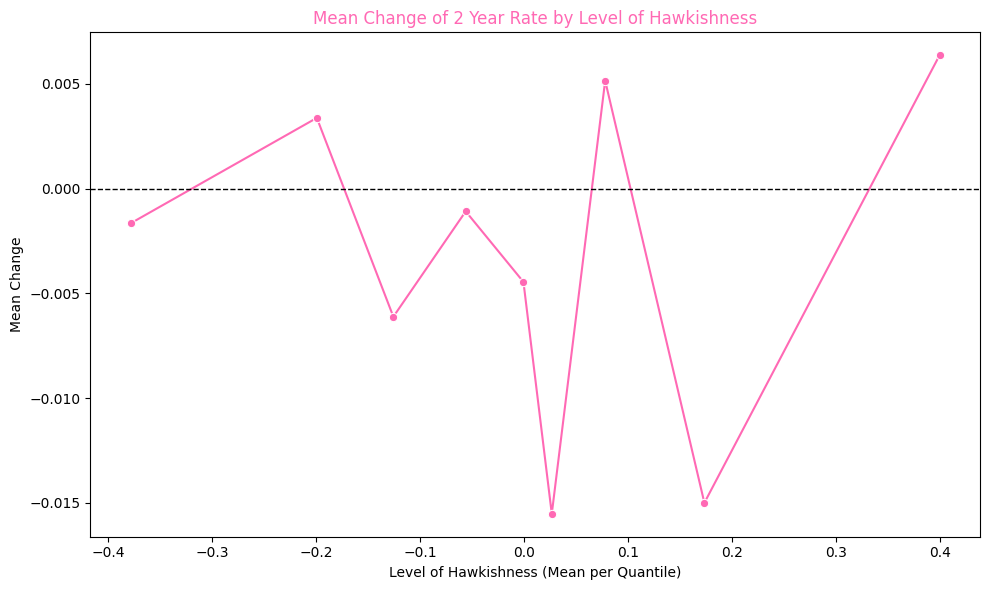

In [122]:
# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 10

# Create quantile bins for hawkish similarity, handling duplicate bin edges
regress['hawkish_quantile'] = pd.qcut(regress['Hawkish Measure'], q=n_quantiles, labels=False, duplicates='drop')

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'Change': 'mean', 'Hawkish Measure': 'mean'})

# Create the figure for the line plot
plt.figure(figsize=(10, 6))

# Plot: Hawkish similarity quantile vs mean 'next_change'
sns.lineplot(x=hawkish_grouped['Hawkish Measure'], y=hawkish_grouped['Change'], color='#FF69B4', marker='o')
# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# Add titles and labels
plt.title('Mean Change of 2 Year Rate by Level of Hawkishness', color='#FF69B4')
plt.xlabel('Level of Hawkishness (Mean per Quantile)')
plt.ylabel('Mean Change')

# Style and show the plot
plt.tight_layout()
plt.show()


In [123]:
X = regress[['Hawkish Measure']]
y = regress['Change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1140
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.736
Time:                        21:30:06   Log-Likelihood:                 1061.3
No. Observations:                 683   AIC:                            -2119.
Df Residuals:                     681   BIC:                            -2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0026      0.002     

When a speech is super hawkish, the market often anticipates more aggressive monetary tightening, such as interest rate increasing or reduced liquidity. This pushes short-term rates (like the 2-year yield) higher, as investors expect borrowing costs to rise in the near future. This relationship is reflected in the graph above, but we observe that it is not linear. When the level of hawkishness is below zero, the mean change in short-term interest rates is less obvious than expected.

However, the regression model fails to capture this effect significantly. The regression results are not statistically significant, and the sign of the coefficient is negative, which is also contrary to expectations.

In [124]:
long = pd.read_excel('/content/drive/MyDrive/GT10.xlsx')
long['Date'] = pd.to_datetime(long['Date'])
# Set 'Date' as the index and sort in descending order
long.set_index('Date', inplace=True)
long.sort_index(ascending=True, inplace=True)
# Check the first few rows
long['Change'] = long['PX_MID'].diff()

In [125]:
regress = df.copy()
regress = pd.merge(regress, long[['Change']], left_on='Date', right_index=True, how='inner')
print(regress.head())

        Date  Hawkish Measure          Source  \
1 2012-01-06        -0.298822        speeches   
3 2012-01-13        -0.125000        speeches   
4 2012-01-16        -0.115385        speeches   
5 2012-01-25        -0.153195  minutes, press   
6 2012-02-16        -0.444444        speeches   

                                       File Name  Change  
1         duke20120106a.txt, raskin20120106a.txt  -0.037  
3                              duke20120113a.txt  -0.060  
4                              duke20120116a.txt   0.000  
5  minutes_20120125.txt, press_conf_20120125.txt  -0.066  
6                          bernanke20120216a.txt   0.056  


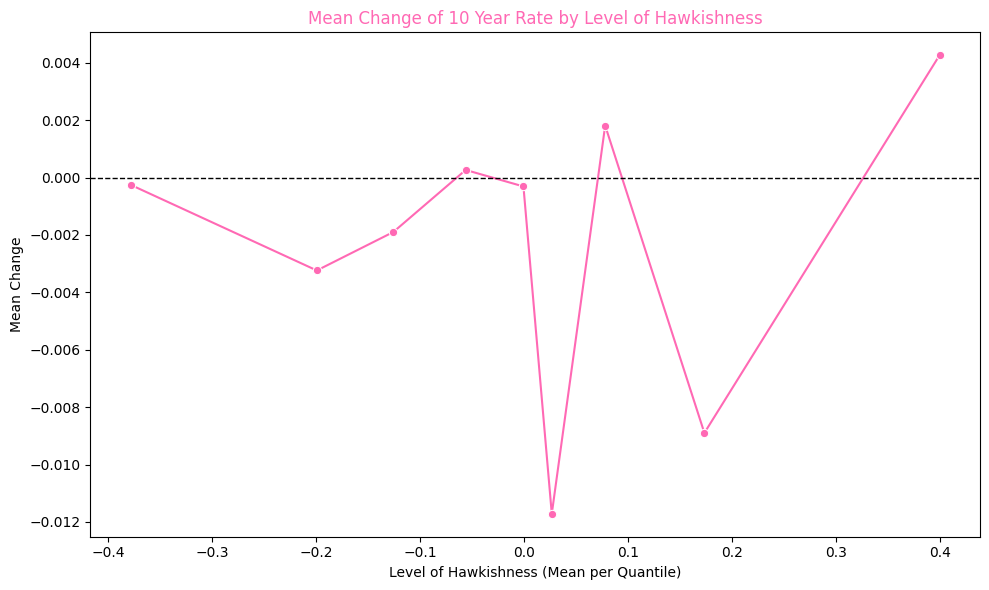

In [126]:
# Replace infinite values with NaN in the 'regress' DataFrame
regress.replace([np.inf, -np.inf], np.nan, inplace=True)

# Define the number of quantiles
n_quantiles = 10

# Create quantile bins for hawkish similarity, handling duplicate bin edges
regress['hawkish_quantile'] = pd.qcut(regress['Hawkish Measure'], q=n_quantiles, labels=False, duplicates='drop')

# Group by the quantile and calculate the mean 'next_change' for each quantile
hawkish_grouped = regress.groupby('hawkish_quantile').agg({'Change': 'mean', 'Hawkish Measure': 'mean'})

# Create the figure for the line plot
plt.figure(figsize=(10, 6))

# Plot: Hawkish similarity quantile vs mean 'next_change'
sns.lineplot(x=hawkish_grouped['Hawkish Measure'], y=hawkish_grouped['Change'], color='#FF69B4', marker='o')
# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# Add titles and labels
plt.title('Mean Change of 10 Year Rate by Level of Hawkishness', color='#FF69B4')
plt.xlabel('Level of Hawkishness (Mean per Quantile)')
plt.ylabel('Mean Change')

# Style and show the plot
plt.tight_layout()
plt.show()

In [127]:
X = regress[['Hawkish Measure']]
y = regress['Change']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.004364
Date:                Sat, 12 Oct 2024   Prob (F-statistic):              0.947
Time:                        21:30:40   Log-Likelihood:                 1004.2
No. Observations:                 683   AIC:                            -2004.
Df Residuals:                     681   BIC:                            -1995.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0012      0.002     

In the most hawkish quantile (around 0.4 level of hawkishness), we observe a sharp positive change in the 10-year yield. This suggests that when the speech is strongly hawkish, the market anticipates that long-term interest rates will rise, possibly due to expectations of prolonged inflation control measures or monetary tightening.  
However, the regression result is still not significant.

### Conclusion
**More dovish tone**: As the level of hawkishness becomes more negative (dovish), the mean next change in the 2-10 year spread tends to increase. Both short-term and long-term yields typically decrease, resulting in a steeper yield curve. This suggests that when the Fed adopts a more dovish tone, the spread widens, leading to larger positive changes in the 2-10 year spread.

**Significant volatility around neutral hawkishness**: At a neutral level of hawkishness (close to 0), there is significant volatility, as seen by sharp spikes in all three plots. This suggests that the market may react more unpredictably when the Fed's tone is ambiguous or neutral, possibly due to increased uncertainty. Alternatively, the data may be noisier when the Fed's stance is less clear.

**More hawkish tone**: As hawkishness increases, the mean change in the 2-10 year spread generally declines. In this case, both short-term and long-term yields tend to rise, which flattens the yield curve.